# Программирование для всех <br>(основы работы с Python)

*Алла Тамбовцева*

## Практикум 6.2. Парсинг HTML с BeautifulSoup: поиск по тэгам и атрибутам

Мы уже немного познакомились со структурой html-страниц, теперь попробуем выгрузить информацию из более интересной страницы, а точнее, с сайта [nplus1.ru](https://nplus1.ru/). Наша задача – выгрузить недавние новости в датафрейм `pandas`, чтобы потом сохранить все в файл CSV.

Для работы нам снова понадобится модуль `requests` для отправки запросов, для «подключения» к странице и получения ее содержимого в виде строки, и функция `BeautifulSoup` из библиотеки `bs4` для удобного поиска по полученной строке:

In [1]:
import requests
from bs4 import BeautifulSoup

<mark>Полезное дополнение</mark>

Так как далее нам придется выключать проверку сертификата страницы при отправке запроса через `requests` во избежание ошибки `SSLError`, функция `get()` будет выдавать предупреждение (сообщение на розовом фоне) о том, что так лучше не делать, если не уверены в безопасности сервера. Так как ничего опасного мы делать не будем, можно отключить заодно и предупреждения такого вида:

In [2]:
from urllib3.exceptions import InsecureRequestWarning
requests.packages.urllib3.disable_warnings(category=InsecureRequestWarning)

Сохраним ссылку на главную страницу в переменную `main` и отправим запрос к ней с помощью функции `get()` из `requests`:

In [3]:
main = "https://nplus1.ru/"
page = requests.get(main, verify = False)

Заберём исходный код страницы и преобразуем строку с ним в объект `BeautifulSoup`:

In [4]:
soup = BeautifulSoup(page.text)

Чтобы сгрузить все новости с главной страницы сайта, нужно собрать все ссылки на страницы с этими новостями. Ссылки в html-файле всегда заключены в тэг `<a></a>` и имеют атрибут `href`. Найдем кусочки кода HTML, соответствующие всем ссылкам на главной странице сайта:

In [5]:
links_raw = soup.find_all("a") 
links_raw[10:20]  # несколько штук для примера

[<a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/search?tags=874">Зоология</a>,
 <a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/search?tags=880">Астрономия</a>,
 <a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/search?tags=768">Генетика</a>,
 <a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/search?tags=890">Математика</a>,
 <a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/search?tags=871">Космонавтика</a>,
 <a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/search?tags=876">Археология</a>,
 <a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/search?tags=775">Нейронауки</a>,
 <a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/search?tags=767">На мышах</a>,
 <a class="hover:underline transition-colors duration-75" href="https://nplus1.ru/se

Каждый элемент возвращаемого списка имеет тип `BeautifulSoup` и структуру, очень похожую на словарь. Например, ссылка `<a class="hover:underline transition-colors duration-75" href="/search/empty/768">Генетика</a>` изнутри выглядит как словарь следующего вида:

    {'href' : '/search/empty/768', 
     'class' : 'hover:underline transition-colors duration-75'}.
    
Как мы помним, значение по ключу из словаря можно вызвать с помощью метода `.get()`. Давайте извлечем значения по ключу `href` из каждого элемента списка `links`:

In [6]:
links = [li.get("href") for li in links_raw]
links[10:20]  # несколько штук для примера

['https://nplus1.ru/search?tags=874',
 'https://nplus1.ru/search?tags=880',
 'https://nplus1.ru/search?tags=768',
 'https://nplus1.ru/search?tags=890',
 'https://nplus1.ru/search?tags=871',
 'https://nplus1.ru/search?tags=876',
 'https://nplus1.ru/search?tags=775',
 'https://nplus1.ru/search?tags=767',
 'https://nplus1.ru/search?tags=771',
 'https://nplus1.ru/search?tags=772']

Ссылок в списке выше много. Но нам нужны только новости – ссылки, которые начинаются с `https://nplus1.ru/news`. Создадим пустой список `news` и будем добавлять в него только ссылки, которые удовлетворяют этому условию.

In [7]:
news = []
for li in links:
    if "https://nplus1.ru/news/" in li:
        news.append(li)

In [8]:
print(news[0:10])

['https://nplus1.ru/news/2025/11/13/aggression-and-self-harm-pathway', 'https://nplus1.ru/news/2025/11/14/new-glenn-first-stage-escapade', 'https://nplus1.ru/news/2025/11/14/tbc-slightly-down', 'https://nplus1.ru/news/2025/11/14/opium-in-ancient-vase', 'https://nplus1.ru/news/2025/11/14/spiders-craft-giant-doppelgangers', 'https://nplus1.ru/news/2025/11/13/diversification-of-dog-morphology', 'https://nplus1.ru/news/2025/11/13/doxy-schizo', 'https://nplus1.ru/news/2025/11/13/sense-of-antisense', 'https://nplus1.ru/news/2025/11/13/aketala', 'https://nplus1.ru/news/2025/11/13/aggression-and-self-harm-pathway']


Теперь наша задача сводится к следующему: изучить одну страницу с новостью, научиться из нее вытаскивать текст и всю необходимую информацию, а потом применить весь набор действий к каждой ссылке из `news` в цикле. Посмотрим на новость с индексом 0, у вас может быть другая, новости обновляются.

In [9]:
link0 = news[0]
print(link0)

https://nplus1.ru/news/2025/11/13/aggression-and-self-harm-pathway


### Задача 1

Отправьте запрос к странице по ссылке `link0` с одной новостью, получите результат в виде объекта `BeautifulSoup` и сохраните его как `soup0`.

In [10]:
page0 = requests.get(link0, verify = False)
soup0 = BeautifulSoup(page0.text)

### Задача 2

Найдите заголовок новости и сохраните его в переменную `title`.

In [11]:
# заменяем неразрывные пробелы \xa0 на обычные

title = soup0.find("title").text.replace("\xa0", " ")
title

'В мозге мышей нашли нейронные контуры агрессии и самоповреждения. Такое поведение запускают возбуждающие нейроны в соединяющем ядре таламуса'

### Задача 3

Найдите имя автора новости и дату её публикации. Сохраните их в `author` и `date` соответственно.

In [12]:
author = soup0.find("meta", {"name" : "author"}).get("content")
date = soup0.find("meta", {"itemprop" : "datePublished"}).get("content")

print(author, date)

Катерина Петрова 2025-11-13


### Задача 4

Найдите сложность новости и рубрики, к которым она относится. Сохраните сложность в переменную `diffc`. Рубрики сначала можно сохранить в список, а затем его элементы объединить в одну строку `rubs`.

**Подсказка:** чтобы упростить себе жизнь, найдите сначала раздел (`div`), в котором на странице хранится дата и время публикации, сложность и рубрики, а затем выполняйте поиск в рамках этого раздела.

In [13]:
# сам раздел
div = soup0.find("div",
           {"class" : "flex flex-wrap lg:mb-10 gap-2 text-tags xl:pr-9"})
div

<div class="flex flex-wrap lg:mb-10 gap-2 text-tags xl:pr-9">
<span class="relative before:block before:w-px before:bg-current before:h-4 before:absolute before:left-0 group pl-2 flex inline-flex items-center">
<span class="group-hover:text-main transition-colors duration-75">11:00</span>
</span>
<a class="relative before:block before:w-px before:bg-current before:h-4 before:absolute before:left-0 group pl-2 flex inline-flex items-center" href="/news/2025/11/13">
<span class="group-hover:text-main transition-colors duration-75">13.11.25</span>
</a>
<a class="relative before:block before:w-px before:bg-current before:h-4 before:absolute before:left-0 group pl-2 flex inline-flex items-center" href="/material/difficulty/4">
<svg class="w-4 h-4 mr-1 group-hover:text-main transition-colors duration-75 stroke-current">
<use xlink:href="#n1_star"></use>
</svg>
<span class="group-hover:text-main transition-colors duration-75">4.7</span>
</a>
<a class="relative before:block before:w-px before:b

In [14]:
# находим все фрагменты <span>
# элемент с индексом 3 содержит сложность,
# оттуда извлекаем текст

diffc = div.find_all("span")[3].text
print(diffc)

4.7


In [15]:
# рубрики идут после сложности, значит, индекс 4
# однако рубрик может быть несколько,
# чтобы забрать все, выбираем все элементы с 4 до конца списка
# из каждого элемента извлекаем текст и склеиваем

rubs_raw = div.find_all("span")[4:]
rubs_list = [r.text for r in rubs_raw]
rubs = ", ".join(rubs_list)
print(rubs)

Биология


### Задача 5

Соберите из абзацев текст новости и сохраните его в переменную `text`. Избавьтесь от постронних символов (`\xa0`, `\n`) в тексте. 

In [16]:
soup0.find_all("p", {"class" : "mb-6"})

[<p class="text-36 md:text-44 xl:text-54 font-spectral text-main-gray mb-6">Такое поведение запускают возбуждающие нейроны в соединяющем ядре таламуса</p>,
 <p class="mb-6">Исследователи из США обнаружили, что нейроны соединяющего ядра таламуса (<em>nucleus reuniens</em>) в мозге мышей управляют агрессивным и самоповреждающим поведением. Стимуляция этих нейронов или детская травма в прошлом усиливали агрессию и аутоагрессию и повышали чувствительность к боли. А ингибирование активности этих нейронов у мышей с детской травмой, напротив, снижало и то, и другое. Чтобы вызвать агрессию, нейроны таламуса передавали сигнал в гиппокамп, а оттуда — в гипоталамус. Для самоповреждения был другой путь — через гиппокамп в миндалевидное тело. Результаты исследования <a href="https://www.science.org/doi/10.1126/sciadv.ady5540" rel="noreferrer noopener" target="_blank">опубликованы</a> в <em>Science Advances</em>.</p>,
 <p class="mb-6">Повышенная агрессия и аутоагрессия нередко сопровождают друг друг

In [17]:
# mb-6 встречается также в class для подзаголовка статьи,
# чтобы не забирать его, берем элементы, начиная со второго (1:)
# далее из каждого элемента списка забираем текст абзаца

pars_raw = soup0.find_all("p", {"class" : "mb-6"})[1:]
pars_list = [p.text for p in pars_raw]
text = " ".join(pars_list)
text = text.replace("\xa0", " ").replace("\n", " ")
print(text)

Исследователи из США обнаружили, что нейроны соединяющего ядра таламуса (nucleus reuniens) в мозге мышей управляют агрессивным и самоповреждающим поведением. Стимуляция этих нейронов или детская травма в прошлом усиливали агрессию и аутоагрессию и повышали чувствительность к боли. А ингибирование активности этих нейронов у мышей с детской травмой, напротив, снижало и то, и другое. Чтобы вызвать агрессию, нейроны таламуса передавали сигнал в гиппокамп, а оттуда — в гипоталамус. Для самоповреждения был другой путь — через гиппокамп в миндалевидное тело. Результаты исследования опубликованы в Science Advances. Повышенная агрессия и аутоагрессия нередко сопровождают друг друга: некоторые исследования показывают, что люди, которые получали медицинскую помощь в связи с самоповреждением, зачастую более склонны к агрессии и чаще совершают насильственные преступления. Такое поведение нередко связано и с детской травмой — например, разлукой с матерью или другим основным опекуном в раннем детстве

<mark>Дополнение</mark>

Как можно заметить, в текст статьи при таком подходе попал еще подзаголовок и начало следующей статьи, так ее фрагмент тоже есть на странице (обычная история для новостей или блогов). 

Как избавиться от лишнего текста? Заметим, что после окончания текущей новости следует подзаголовок следующей (у заголовков нет тэга `<p>`, поэтому в перечне абзацев выше их нет) и её фрагмент. Поэтому для универсального удаления лишнего текста нужно забрать все элементы из `pars_raw` до подзаголовка.

In [18]:
# заберем все значения атрибута class -> classes
# сейчас в classes списки с элементами внутри class
# для каждого элемента в pars_list

classes = [p.get("class") for p in pars_raw]
print(classes)

[['mb-6'], ['mb-6'], ['mb-6'], ['mb-6'], ['mb-6'], ['mb-6'], ['mb-6'], ['mb-6'], ['mb-6'], ['text-36', 'md:text-44', 'xl:text-54', 'font-spectral', 'text-main-gray', 'mb-6'], ['mb-6']]


In [19]:
# переберем все элементы и найдем индекс того, где 
# есть text-main-gray – такое есть только у подзаголовков,
# они серого цвета, а не черного

for c in classes:
    if "text-main-gray" in c:
        i = classes.index(c)
        break
        
print(i)

9


In [20]:
# заберем все элементы до i
# теперь это абзацы только первой новости

pars_upd = pars_raw[:i]
text = " ".join([p.text for p in pars_upd])
text = text.replace("\xa0", " ").replace("\n", " ")
print(text)

Исследователи из США обнаружили, что нейроны соединяющего ядра таламуса (nucleus reuniens) в мозге мышей управляют агрессивным и самоповреждающим поведением. Стимуляция этих нейронов или детская травма в прошлом усиливали агрессию и аутоагрессию и повышали чувствительность к боли. А ингибирование активности этих нейронов у мышей с детской травмой, напротив, снижало и то, и другое. Чтобы вызвать агрессию, нейроны таламуса передавали сигнал в гиппокамп, а оттуда — в гипоталамус. Для самоповреждения был другой путь — через гиппокамп в миндалевидное тело. Результаты исследования опубликованы в Science Advances. Повышенная агрессия и аутоагрессия нередко сопровождают друг друга: некоторые исследования показывают, что люди, которые получали медицинскую помощь в связи с самоповреждением, зачастую более склонны к агрессии и чаще совершают насильственные преступления. Такое поведение нередко связано и с детской травмой — например, разлукой с матерью или другим основным опекуном в раннем детстве

### Задача 6

Напишите функцию `get_news()`, которая принимает на вход ссылку на страницу с одной новостью, а возвращает список из следующих характеристик: имя автора, дата публикации, сложность новости, рубрики, текст новости.

In [21]:
# правда, наша функция возвращает кортеж, а не список,
# но тут неважно

def get_news(link0):
    page0 = requests.get(link0, verify = False)
    soup0 = BeautifulSoup(page0.text)
    title = soup0.find("title").text.replace("\xa0", " ")
    author = soup0.find("meta", {"name" : "author"}).get("content")
    date = soup0.find("meta", {"itemprop" : "datePublished"}).get("content")
    div = soup0.find("div",
           {"class" : "flex flex-wrap lg:mb-10 gap-2 text-tags xl:pr-9"})
    diffc = div.find_all("span")[3].text
    rubs_raw = div.find_all("span")[4:]
    rubs_list = [r.text for r in rubs_raw]
    rubs = ", ".join(rubs_list)
    pars_raw = soup0.find_all("p", {"class" : "mb-6"})[1:]
    pars_list = [p.text for p in pars_raw]
    text = " ".join(pars_list)
    text = text.replace("\xa0", " ").replace("\n", " ")
    return title, author, date, diffc, rubs, text

<mark>Дополнение</mark>

Вариант функции с учетом дополнения из задачи №5 (плюс, с документацией для порядка):

In [22]:
def get_news(link0):
    """
    Parameters:
        link0 – url for one piece of news (string)
    Returns:
         a tuple of the following features:
            * new's title (string)
            * new's date (string)
            * new's author (string)
            * new's difficulty (string)
            * new's rubrics (string)
            * new's text (string)
    """
    page0 = requests.get(link0)
    soup0 = BeautifulSoup(page0.text)
    
    title = soup0.find("title").text.replace("\xa0", " ")
    date = soup0.find("meta", {"itemprop" : "datePublished"}).get("content")
    author = soup0.find("meta", {"name" : "author"}).get("content")
    div = soup0.find("div", {"class" : "flex flex-wrap lg:mb-10 gap-2 text-tags xl:pr-9"})
    spans = div.find_all("span")
    diffc = spans[3].text
    rubs_raw = spans[4:]
    rubs = ", ".join([r.text for r in rubs_raw])
    
    # для текста – более универсальный вариант без лишней новости
    classes = [p.get("class") for p in pars_raw]
    for c in classes:
        if "text-main-gray" in c:
            i = classes.index(c)
    pars_upd = pars_raw[:i]
    text = " ".join([p.text for p in pars_upd])
    text = text.replace("\xa0", " ").replace("\n", " ")
    
    return title, author, date, diffc, rubs, text

**Важно!** Проверим работу функции перед запуском цикла:

In [23]:
get_news(news[0])

('В мозге мышей нашли нейронные контуры агрессии и самоповреждения. Такое поведение запускают возбуждающие нейроны в соединяющем ядре таламуса',
 'Катерина Петрова',
 '2025-11-13',
 '4.7',
 'Биология',
 'Исследователи из США обнаружили, что нейроны соединяющего ядра таламуса (nucleus reuniens) в мозге мышей управляют агрессивным и самоповреждающим поведением. Стимуляция этих нейронов или детская травма в прошлом усиливали агрессию и аутоагрессию и повышали чувствительность к боли. А ингибирование активности этих нейронов у мышей с детской травмой, напротив, снижало и то, и другое. Чтобы вызвать агрессию, нейроны таламуса передавали сигнал в гиппокамп, а оттуда — в гипоталамус. Для самоповреждения был другой путь — через гиппокамп в миндалевидное тело. Результаты исследования опубликованы в Science Advances. Повышенная агрессия и аутоагрессия нередко сопровождают друг друга: некоторые исследования показывают, что люди, которые получали медицинскую помощь в связи с самоповреждением, зача

In [26]:
get_news(news[7])

('Антисмысловой олигонуклеотид снизил резко повышенный уровень триглицеридов. Частота острого панкреатита тоже снижалась',
 'Олег Лищук',
 '2025-11-13',
 '3.1',
 'Медицина',
 'Исследователи из США обнаружили, что нейроны соединяющего ядра таламуса (nucleus reuniens) в мозге мышей управляют агрессивным и самоповреждающим поведением. Стимуляция этих нейронов или детская травма в прошлом усиливали агрессию и аутоагрессию и повышали чувствительность к боли. А ингибирование активности этих нейронов у мышей с детской травмой, напротив, снижало и то, и другое. Чтобы вызвать агрессию, нейроны таламуса передавали сигнал в гиппокамп, а оттуда — в гипоталамус. Для самоповреждения был другой путь — через гиппокамп в миндалевидное тело. Результаты исследования опубликованы в Science Advances. Повышенная агрессия и аутоагрессия нередко сопровождают друг друга: некоторые исследования показывают, что люди, которые получали медицинскую помощь в связи с самоповреждением, зачастую более склонны к агресси

Отлично! Теперь осталось применить функцию ко всем ссылкам в списке `news`. Чтобы сайт не понял, что мы его автоматически грабим, будем выгружать новости постепенно – с задержкой в 1.2 секунды. Импортируем для этого функцию `sleep` :

In [27]:
from time import sleep

Теперь будем применять функцию в цикле к каждой ссылке в `news`, только с одним дополнением – добавленной конструкцией `try-except`, которая позволит продолжать исполнение цикла, если при применении функции Python столкнулся с ошибкой любого вида:

In [28]:
info = []
for n in news:
    # пробуй исполнить следующий код
    try:
        res = get_news(n)
        info.append(res)
        print(n)
    # если он вызвал ошибку любого вида, печатай сообщение и иди дальше
    except:
        print("Something went wrong")
        print(n)
    sleep(1.2)

https://nplus1.ru/news/2025/11/13/aggression-and-self-harm-pathway
https://nplus1.ru/news/2025/11/14/new-glenn-first-stage-escapade
https://nplus1.ru/news/2025/11/14/tbc-slightly-down
https://nplus1.ru/news/2025/11/14/opium-in-ancient-vase
https://nplus1.ru/news/2025/11/14/spiders-craft-giant-doppelgangers
https://nplus1.ru/news/2025/11/13/diversification-of-dog-morphology
https://nplus1.ru/news/2025/11/13/doxy-schizo
https://nplus1.ru/news/2025/11/13/sense-of-antisense
https://nplus1.ru/news/2025/11/13/aketala
https://nplus1.ru/news/2025/11/13/aggression-and-self-harm-pathway
https://nplus1.ru/news/2025/11/13/microdosed-at-home
https://nplus1.ru/news/2025/11/12/ty
https://nplus1.ru/news/2025/11/12/selective-amylin-agonist
https://nplus1.ru/news/2025/11/12/record-glacier-retreat
https://nplus1.ru/news/2025/11/12/hypnotize-mesmerize
https://nplus1.ru/news/2025/11/11/megachile-lucifer
https://nplus1.ru/news/2025/11/11/bath-freely
https://nplus1.ru/news/2025/11/11/antiaterocrispr
https://

Посмотрим на длину списка `info` и первые два элемента:

Финальный штрих – импортируем `pandas` и преобразуемый полученный список кортежей в таблицу (датафрейм):

In [30]:
import pandas as pd

In [31]:
df = pd.DataFrame(info)
df

,0,1,2,3,4,5
0,В мозге мышей нашли нейронные контуры агрессии...,Катерина Петрова,2025-11-13,4.7,Биология,"Исследователи из США обнаружили, что нейроны с..."
1,Blue Origin впервые вернула первую ступень рак...,Александр Войтюк,2025-11-14,3.9,Космонавтика,"Исследователи из США обнаружили, что нейроны с..."
2,Заболеваемость туберкулезом в мире снизилась в...,Олег Лищук,2025-11-14,1.1,Медицина,"Исследователи из США обнаружили, что нейроны с..."
3,В древнем алабастроне нашли остатки опиума. Во...,Михаил Подрезов,2025-11-14,2.5,"Археология, Химия","Исследователи из США обнаружили, что нейроны с..."
4,Пауки сделали фальшивых пауков втрое крупнее с...,Сергей Коленов,2025-11-14,3.7,Зоология,"Исследователи из США обнаружили, что нейроны с..."
5,Древнейшим черепом с действительно собачьей мо...,Михаил Подрезов,2025-11-13,4.1,"Археология, Зоология","Исследователи из США обнаружили, что нейроны с..."
6,Прием доксициклина подростками связали со сниж...,Олег Лищук,2025-11-13,1.8,Медицина,"Исследователи из США обнаружили, что нейроны с..."
7,Антисмысловой олигонуклеотид снизил резко повы...,Олег Лищук,2025-11-13,3.1,Медицина,"Исследователи из США обнаружили, что нейроны с..."
8,На западе Таримской впадины обнаружили поселен...,Михаил Подрезов,2025-11-13,2.1,Археология,"Исследователи из США обнаружили, что нейроны с..."
9,В мозге мышей нашли нейронные контуры агрессии...,Катерина Петрова,2025-11-13,4.7,Биология,"Исследователи из США обнаружили, что нейроны с..."


Добавим содержательные названия столбцов – запишем в атрибут `.column` список из шести значений:

In [32]:
df.columns = ["title", "author", "date", "diffc", "rubrics", "text"]

# head – показывает перавы 5 строк
df.head()

,title,author,date,diffc,rubrics,text
0,В мозге мышей нашли нейронные контуры агрессии...,Катерина Петрова,2025-11-13,4.7,Биология,"Исследователи из США обнаружили, что нейроны с..."
1,Blue Origin впервые вернула первую ступень рак...,Александр Войтюк,2025-11-14,3.9,Космонавтика,"Исследователи из США обнаружили, что нейроны с..."
2,Заболеваемость туберкулезом в мире снизилась в...,Олег Лищук,2025-11-14,1.1,Медицина,"Исследователи из США обнаружили, что нейроны с..."
3,В древнем алабастроне нашли остатки опиума. Во...,Михаил Подрезов,2025-11-14,2.5,"Археология, Химия","Исследователи из США обнаружили, что нейроны с..."
4,Пауки сделали фальшивых пауков втрое крупнее с...,Сергей Коленов,2025-11-14,3.7,Зоология,"Исследователи из США обнаружили, что нейроны с..."


Выведем техническое описание датафрейма, чтобы узнать, какие в нем типы столбцов:

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    52 non-null     object
 1   author   52 non-null     object
 2   date     52 non-null     object
 3   diffc    52 non-null     object
 4   rubrics  52 non-null     object
 5   text     52 non-null     object
dtypes: object(6)
memory usage: 2.6+ KB


Все столбцы имеют тип `object`, так в `pandas` называется текстовый тип (как `str`). Для названия, автора, текста статьи и рубрик это оправдано, а вот сложность статьи по-хорошему должна быть сохранена в виде дробных чисел. Дату тоже хорошо бы привести к типу `datetime`, чтобы мы смогли выполнять хронологическую сортировку новостей, строить всякие графики для динамики и извлекать из даты день недели. Но мы остановимся только на сложности. Изменим тип столбца на `float` и перезапишем столбец:

In [34]:
df["diffc"] = df["diffc"].astype(float)

In [35]:
# сработало
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    52 non-null     object 
 1   author   52 non-null     object 
 2   date     52 non-null     object 
 3   diffc    52 non-null     float64
 4   rubrics  52 non-null     object 
 5   text     52 non-null     object 
dtypes: float64(1), object(5)
memory usage: 2.6+ KB


Теперь, пользуясь тем, что сложность представлена в числовом виде, можем построить для нее гистограмму:

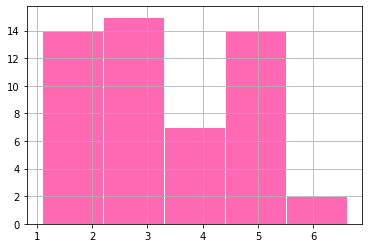

In [36]:
# теперь можно строить гистограмму
# bins = 5, пять столбцов
# color – цвет заливки
# edgecolor – цвет границ столбцов

df["diffc"].hist(color = "hotpink", edgecolor = "white", bins = 5);

Список названий цветов, которые поддерживаются графической библиотекой Python (активируется внутри `pandas`), можно найти [здесь](https://matplotlib.org/stable/gallery/color/named_colors.html).

Из-за наличия одинаковых ссылок некоторые новости выгрузились два раза (по-хорошему это надо было поправить в самом начале на этапе создания списка news, чтобы не тратить время на выгрузку одного и того же, но уже поздно). Чтобы убрать дубликаты из датафрейма, можно воспользоваться методом `.drop_duplicates()`:

In [37]:
# inplace = True, сохранить изменения в df
# буквально – на месте (in place) старого датафрейма

df.drop_duplicates(inplace = True)

Теперь строк стало меньше:

In [38]:
# было 52, стало 48

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48 entries, 0 to 48
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   title    48 non-null     object 
 1   author   48 non-null     object 
 2   date     48 non-null     object 
 3   diffc    48 non-null     float64
 4   rubrics  48 non-null     object 
 5   text     48 non-null     object 
dtypes: float64(1), object(5)
memory usage: 2.6+ KB


Экспортируем таблицу в файлы CSV и Excel:

In [39]:
df.to_csv("nplus1.csv")

In [40]:
df.to_excel("nplus1.xlsx")

Теперь файлы `nplus1.csv` и `nplus1.xlsx` появились в рабочей папке (рядом с текущим `.ipynb`, видно в *Home* в Jupyter). Если по виду папки в *Home* непонятно, что это за папка, можно импортировать базовый модуль `os` для работы с операционной системой и запросить путь к текущей рабочей папке: 

In [41]:
import os

# get current working directory
os.getcwd()

'/Users/allat/Dropbox/ВШЭ - работа/Кафедра высшей математики/2025-2026/Python для всех/week06'